
Aggregate business data by suburb:
   Year                     Suburb  Business Count      Jobs
0  2011                    Carlton            1160   14273.0
1  2011  City of Melbourne (total)           31954  863117.0
2  2011                  Docklands             865   29810.0
3  2011             East Melbourne             593   15753.0
4  2011                 Kensington             441    3784.0
Total students summary:
 Cohort_1_2005_2023    3278655.0
Cohort_2_2024          825131.0
Total                 4103786.0
dtype: float64

Correlation between student count and business variables:
                Student Count  Business Count      Jobs
Student Count        1.000000        0.906047  0.904976
Business Count       0.906047        1.000000  0.998643
Jobs                 0.904976        0.998643  1.000000


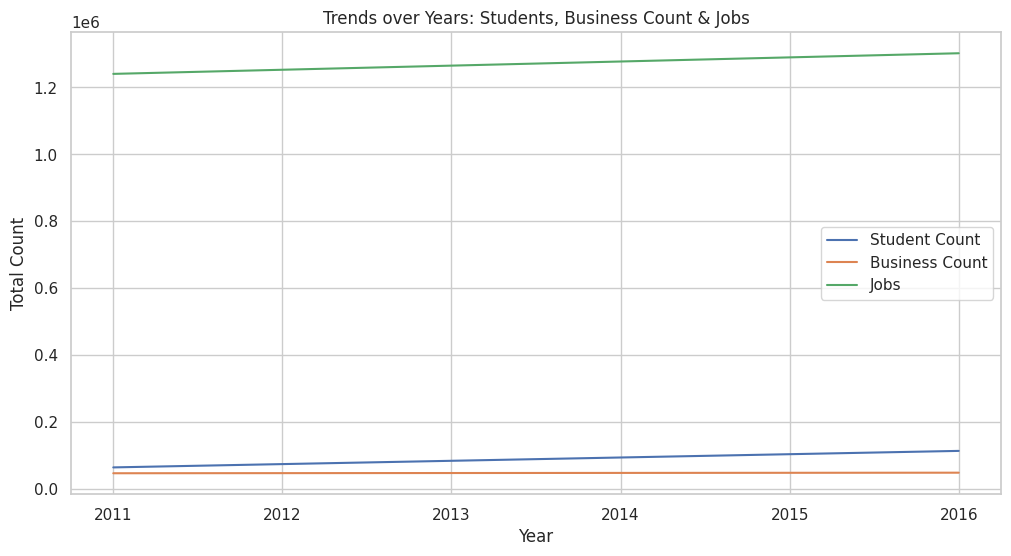

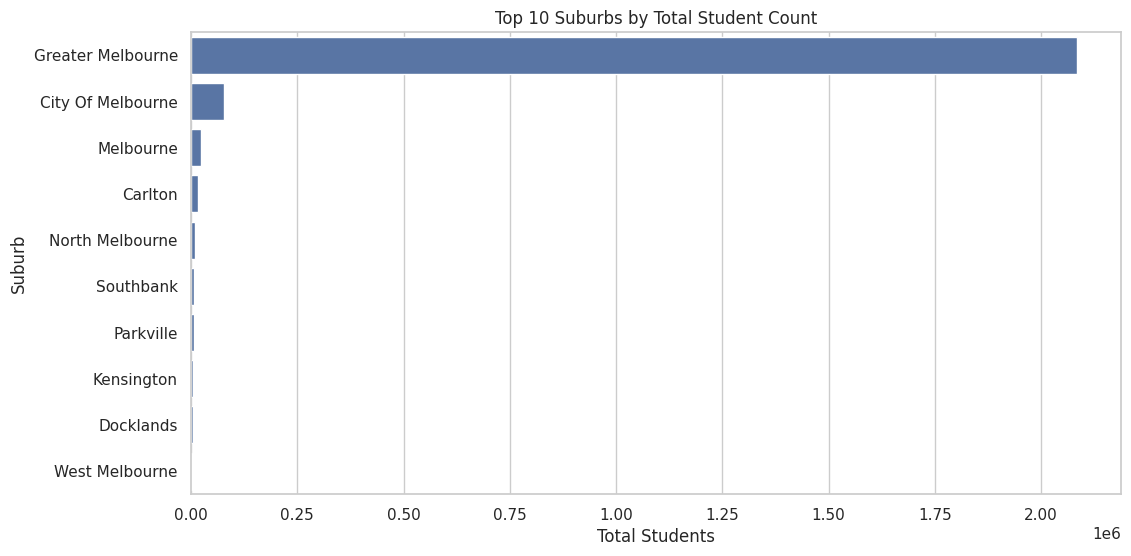

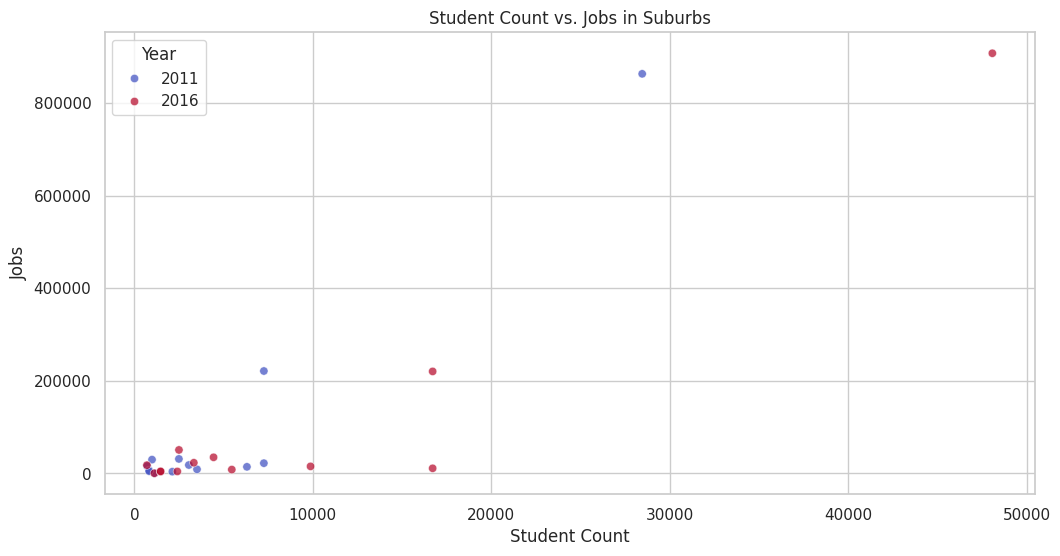

In [ ]:
# =============================
# 1. Importing Required Libraries
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# =============================
# 2. Load Datasets
# =============================

students_df = pd.read_excel("International_students.xlsx", header=17)
residents_df = pd.read_excel("residents-profiles-by-clue-small-area.xlsx")
business_df = pd.read_excel("business-establishments-and-jobs-data-by-business-size-and-industry.xlsx")

# =============================
# 3. Data Cleaning & Preprocessing
# =============================

# Drop the first column
students_df = students_df.iloc[:, 1:]

# Rename columns
students_df.columns = ['Nationality','Cohort_1_2005_2023', 'Cohort_2_2024', 'Total']

business_df.rename(columns={
    "Census year": "Year",
    "CLUE small area": "Suburb",
    "ANZSIC indusrty": "ANZSIC Industry",
    "CLUE industry": "CLUE Industry",
    "Business size": "Business Size",
    "Total establishments": "Business Count",
    "Total jobs": "Jobs"
}, inplace=True)

# Inspect
# print("Students file preview:")
# print(students_df)

# --- Rename columns in residents_df BEFORE filtering ---
residents_df.rename(columns={
    'geography': 'Suburb',
    'year': 'Year',
    'value': 'Student Count'
}, inplace=True)


# --- Filter education-related student attendance data ---
edu_students = residents_df[
    (residents_df['category'].str.lower() == 'education institution attendance') &
    (residents_df['sub_category'].str.lower() == 'attending')
].copy()

# Clean whitespace and casing
edu_students['Suburb'] = edu_students['Suburb'].str.title().str.strip()

# print("\nBusiness file preview:")
# print(business_df)
# print("\nResident file preview:")
# print(edu_students)

# =============================
# 4. Exploratory Data Analysis
# =============================
# Aggregate business data by suburb and year
print("\nAggregate business data by suburb:")
business_agg = business_df.groupby(['Year', 'Suburb']).agg({
    'Business Count': 'sum',
    'Jobs': 'sum'
}).reset_index()

print(business_agg.head())

# Summarize student data at cohort level (overall)
students_summary = students_df[['Cohort_1_2005_2023', 'Cohort_2_2024', 'Total']].sum()
print("Total students summary:\n", students_summary)

students_agg = edu_students.groupby(['Year', 'Suburb'])['Student Count'].sum().reset_index()

business_agg['Suburb'] = business_agg['Suburb'].str.strip().str.replace(r'\s*\(.*?\)', '', regex=True).str.title()
students_agg['Suburb'] = students_agg['Suburb'].str.strip().str.replace(r'\s*\(.*?\)', '', regex=True).str.title()

# =============================
# 5. Merge and Correlation Analysis
# =============================
# Ensure Year is integer in both
students_agg['Year'] = pd.to_numeric(students_agg['Year'], errors='coerce').astype('Int64')
business_agg['Year'] = pd.to_numeric(business_agg['Year'], errors='coerce').astype('Int64')

# Merge student and business data by suburb and year
merged_df = pd.merge(students_agg, business_agg, on=['Year', 'Suburb'])

merged_df['Student Count'] = pd.to_numeric(merged_df['Student Count'], errors='coerce')
merged_df['Business Count'] = pd.to_numeric(merged_df['Business Count'], errors='coerce')
merged_df['Jobs'] = pd.to_numeric(merged_df['Jobs'], errors='coerce')

# CORRELATION ANALYSIS
print("\nCorrelation between student count and business variables:")
print(merged_df[['Student Count', 'Business Count', 'Jobs']].corr())

# =============================
# 6. Visual Analysis
# =============================

# --- Trend of students vs. businesses over years ---
yearly_trends = merged_df.groupby('Year')[['Student Count', 'Business Count', 'Jobs']].sum().reset_index()

plt.figure()
sns.lineplot(data=yearly_trends, x='Year', y='Student Count', label='Student Count')
sns.lineplot(data=yearly_trends, x='Year', y='Business Count', label='Business Count')
sns.lineplot(data=yearly_trends, x='Year', y='Jobs', label='Jobs')
plt.title('Trends over Years: Students, Business Count & Jobs')
plt.xlabel('Year')
plt.ylabel('Total Count')
plt.legend()
plt.show()

# --- Top 10 student suburbs ---
top_suburbs = students_agg.groupby('Suburb')['Student Count'].sum().sort_values(ascending=False).head(10)

plt.figure()
sns.barplot(x=top_suburbs.values, y=top_suburbs.index, orient='h')
plt.title('Top 10 Suburbs by Total Student Count')
plt.xlabel('Total Students')
plt.ylabel('Suburb')
plt.show()

# --- Relationship scatterplot: Students vs. Jobs ---
plt.figure()
sns.scatterplot(data=merged_df, x='Student Count', y='Jobs', hue='Year', palette='coolwarm', alpha=0.7)
plt.title('Student Count vs. Jobs in Suburbs')
plt.xlabel('Student Count')
plt.ylabel('Jobs')
plt.show()
